## Author:  Nolan Kowitt

The code below connects to a Keysight DSOX3014G

In all examples below we use Channel1 of the scope -- C1 for short. You can always change it to C2.

* Documentation: https://www.batronix.com/files/Keysight/Oszilloskope/3000XT/3000XT-Programming.pdf

Requirements:

* pyvisa


In [434]:
import numpy as np
import pyvisa
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm #This is optional just if you want a progress bar
plt.rcParams['figure.figsize'] = [10, 5]

In [230]:
rm = pyvisa.ResourceManager()
rm.list_resources()
scope = rm.open_resource('USB0::0x2A8D::0x1768::MY62510218::INSTR')
print(scope.query("*IDN?"))

KEYSIGHT TECHNOLOGIES,DSO-X 3014G,MY62510218,07.57.2023033130



In [240]:
scope.write('*RST')# Puts the scope into a KNOWN state, but will kill any settings you have, so run with caution

6

In [241]:
CH1Range = 0.2 #FULL SCALE RANGE [V]
TIMEBASE = 100e-6 #FULL TIME RANGE [s]

scope.write(':CHAN1:DISP 1 ')
scope.write(':CHAN2:DISP 1 ')

scope.write(f':CHAN1:RANG {CH1Range}')
scope.write(f':CHAN2:RANG {CH2Range}')

scope.write(f':CHAN1:OFFS {CH1Range/2-CH1Range*0.05}')
scope.write(f':CHAN2:OFFS {CH2Range/2-CH2Range*0.05}')

scope.write(f':TIM:RANG {TIMEBASE}')

18

In [433]:
def aquire(npoints):
    ampoutmax = np.zeros(npoints)
    ampoutarea= np.zeros(npoints)
    scope.write(':MEAS:STAT:DISP 1')
    scope.write(':MEAS:STAT CURR')
    scope.write(':MEAS:STAT:RES')
    scope.write(':MEAS:VMIN')
    scope.write(':MEAS:AREA')
    for i in tqdm(range(npoints)):
        trigflag = 0
        while trigflag==0:
            trigflag = scope.query(':TER?')[1]
        val = scope.query(':MEAS:RES? ').split(',')
        ampoutmax[i] = val[0]
        ampoutarea[i]= val[1]

    return ampoutmax,ampoutarea

In [358]:

CSheight,CSarea = aquire(100000)


  0%|          | 0/100000 [00:00<?, ?it/s]

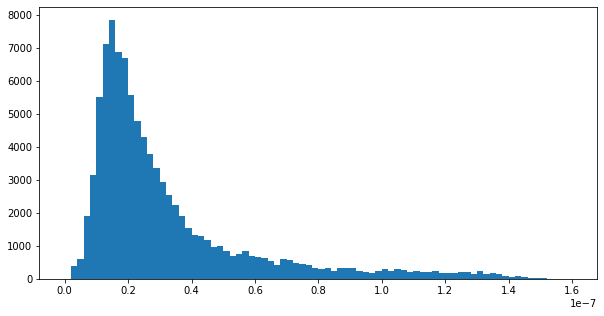

In [429]:
plt.figure()
measured_counts_br, bin_edges_br,patches = plt.hist(np.abs(BRarea),80,[0,1.6e-7]);

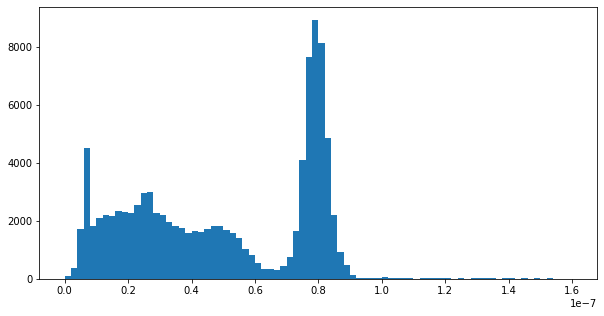

In [428]:
plt.figure()
measured_counts_CS, bin_edges_CS,patches = plt.hist(np.abs(CSarea),80,[0,1.6e-7]);


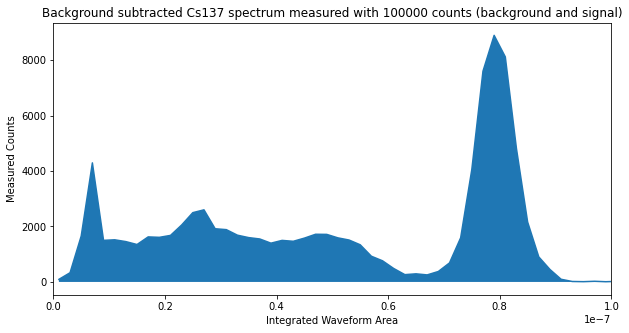

In [432]:
bin_center = (bin_edges_CS[1:]+bin_edges_CS[:-1])/2
mask = bin_center>1e-7

normalization = np.sum(measured_counts_CS[mask])/np.sum(measured_counts_br[mask])
brsub = measured_counts_CS-measured_counts_br*normalization
plt.figure()
plt.plot(bin_center,brsub)
plt.fill_between(bin_center,0,brsub)
plt.xlim([0,1e-7])
plt.xlabel('Integrated Waveform Area')
plt.ylabel('Measured Counts')
plt.title('Background subtracted Cs137 spectrum measured with 100000 counts (background and signal)');
